In [1]:
# import spherical_functions as sf
# import quaternion
# from scipy.special import lpmn as pl
from scipy.special import eval_legendre as pl
from multiprocessing import Pool,cpu_count
from functools import partial
import mpmath

from scipy.special import poch,hyp2f1,gamma,loggamma



In [2]:
def hyper2f1(a,b,c,z):
    h=loggamma(c)-loggamma(b)-loggamma(c-b)
    
    t=np.linspace(0,1,1000)
    dt=np.gradient(t)
    
    i_log=t*(b-1.)
    i_log+=(1.-t)*(c-b-1)
    i_log-=(1.-t*z)*a
    i=np.exp(i_log)
    h+=np.log(np.sum(i*dt))
    print(h)
    return np.exp(h)

In [3]:
n=1
# n=np.arange(1.e4,1.001e4)
a=1
b=4
z=0.9
print(hyp2f1(n,a,b,z))
print(hyper2f1(n,a,b,z))

# %time print (hyp2f1(-n,1.+a+b+n, 1+a, z))
# %time print (hyp2f1(1+a+n,b+n, 1+a, z))
# %time print (hyp2f1(-n,1.+a+b+n, 1+a, 1-z))
# %time print (hyp2f1(-n,1.+a+b+n, 1+a, z/(z-1)))
# %time print (mpmath.hyp2f1(-n,1.+a+b+n, 1+a, z,maxprec=10**30))
# %time print (hyper2f1(-n,1.+a+b+n, 1+a, z))

1.3910528844853505
1.5996295880322284
4.951198101656879


In [4]:
from scipy.special import binom,jn,loggamma
#from scipy.special import hyp2f1 as h21
from scipy.special import eval_jacobi as jacobi

In [5]:
def jacobi2(a,b,cos_theta,l):
    j=jacobi(l,a,b,cos_theta)
    print (j.shape,l,a,cos_theta.shape)
    return 

def wigner_d(m1,m2,theta,l,l_use_bessel=1.e4):
    l0=np.copy(l)
    if l_use_bessel is not None:
        l=np.atleast_1d(l)
        x=l<l_use_bessel
        l=np.atleast_1d(l[x])
    k=np.amin([l-m1,l-m2,l+m1,l+m2],axis=0)
    a=np.absolute(m1-m2)
    lamb=0 #lambda
    if m2>m1:
        lamb=m2-m1
    b=2*l-2*k-a
    d_mat=(-1)**lamb
    d_mat*=np.sqrt(binom(2*l-k,k+a)) #this gives array of shape l with elements choose(2l[i]-k[i], k[i]+a)
    d_mat/=np.sqrt(binom(k+b,b))
    d_mat=np.atleast_1d(d_mat)
    x=k<0
    d_mat[x]=0
    d_mat=d_mat.reshape(1,len(d_mat))
    theta=theta.reshape(len(theta),1)
    d_mat=d_mat*((np.sin(theta/2.0)**a)*(np.cos(theta/2.0)**b))
    d_mat*=jacobi(l,a,b,np.cos(theta))
    if l_use_bessel is not None:
        l=np.atleast_1d(l0)
        x=l>=l_use_bessel
        l=np.atleast_1d(l[x])
#         print(d_mat.shape,jn(m1-m2,l*theta).shape)
        d_mat=np.append(d_mat,jn(m1-m2,l*theta),axis=1)
#         crash
#     x2=np.isnan(d_mat)
#     x=np.where(x2)
#     l=np.atleast_1d(l)
#     d_mat[x2]=jn(m1-m2,l[x[1]]*theta[x[0],0])
    
    return d_mat        

In [6]:
l=np.arange(1e4,1.1e4)#+1000
m1=2
m2=2
d2r=np.pi/180.
theta=np.linspace(0.1,5,20)*d2r

In [7]:
dm=wigner_d(m1,m2,theta,np.arange(1.e3,1.001e4))

In [54]:
dm=wigner_d(m1,m2,theta,np.arange(1.e4,1.001e4))

In [55]:
%time dm=wigner_d(m1,m2,theta,l)

CPU times: user 6.81 ms, sys: 0 ns, total: 6.81 ms
Wall time: 6.06 ms


In [56]:
dm.shape

(20, 1000)

In [59]:
p=Pool(5)
%time dm2=array(p.map(partial(wigner_d,m1,m2,theta,l_use_bessel=1.e4),l))
dm2=dm2[:,:,0].T

CPU times: user 14.8 ms, sys: 99 µs, total: 14.9 ms
Wall time: 34.8 ms


In [60]:
dm2.shape

(20, 1000)

In [299]:
np.any(np.isnan(dm2))

True

In [259]:
%time pl0=pl(l,np.cos(theta).reshape(len(theta),1))

CPU times: user 5.32 s, sys: 20.9 ms, total: 5.34 s
Wall time: 5.27 s


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


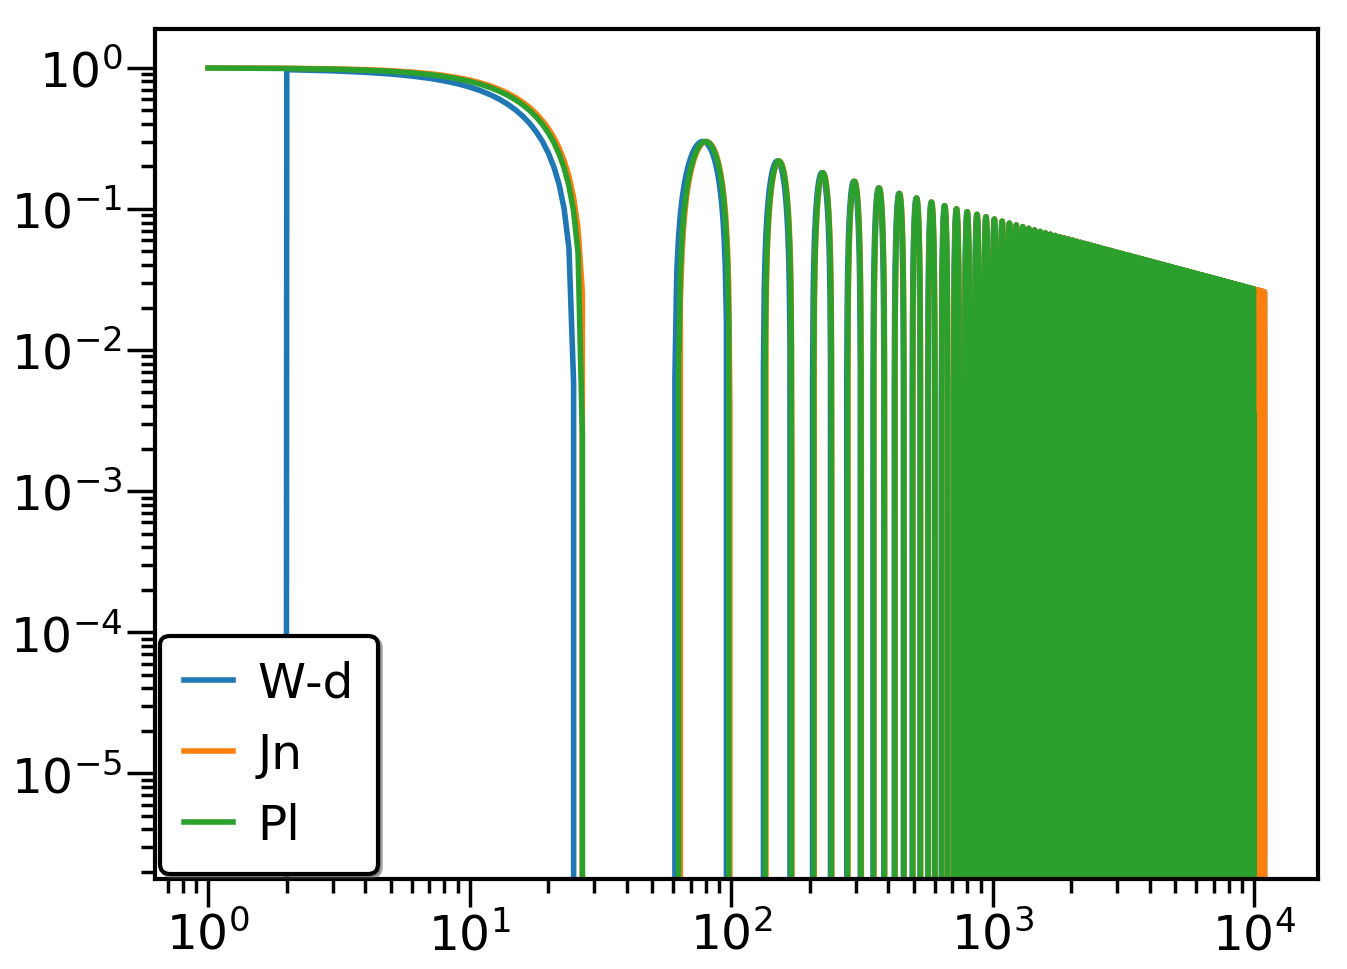

In [260]:
i=-1
plot(l,dm[i],label='W-d')
plot(l,jn(m1-m2,l*theta[i]),label='Jn')
plot(l,pl0[i],label='Pl')
xscale('log')
yscale('log')
legend()
# xlim(655,700)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


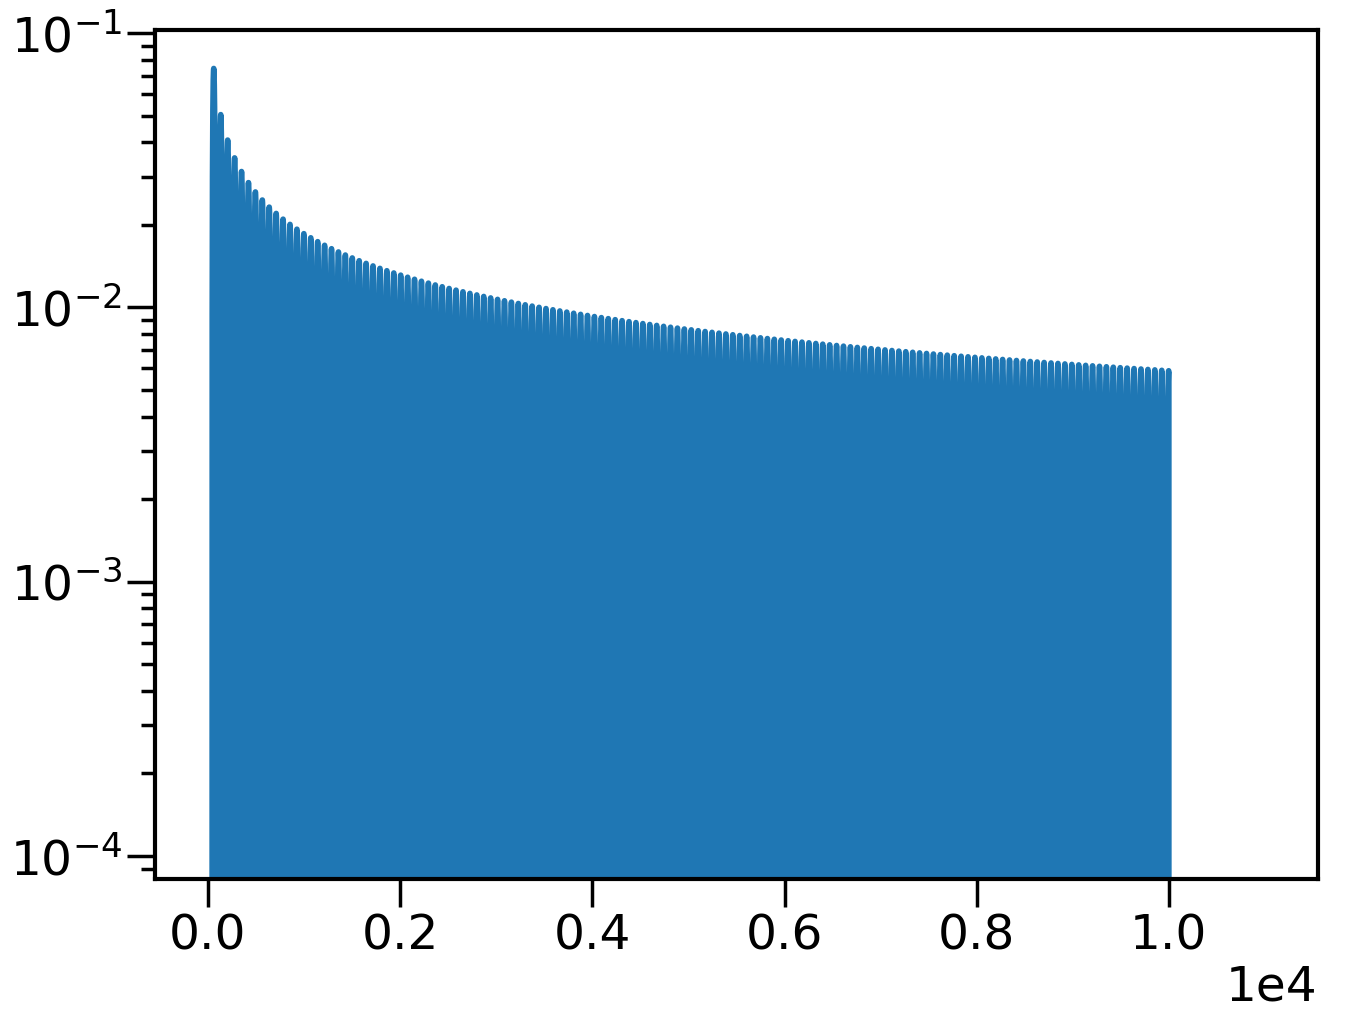

In [262]:
plot(l,dm[i]-jn(m1-m2,l*theta[i]))
# xscale('log')
yscale('log')

In [8]:
from sympy.physics.wigner import wigner_3j

In [9]:
def log_factorial(n):
    return loggamma(n+1)
#     if n==0:
#         return 0
#     if n<0:
#         return np.nan
#     return n*np.log(n) -n +0.5*np.log(2*np.pi*n) + 1./12./n-1./360./n**3

In [19]:
def Wigner3j_log_vec(j_1, j_2, j_3, m_1, m_2, m_3):
    """Calculate the Wigner 3j symbol `Wigner3j(j_1,j_2,j_3,m_1,m_2,m_3)`

    This function is copied with minor modification from
    sympy.physics.Wigner, as written by Jens Rasch.

    The inputs must be integers.  (Half integer arguments are
    sacrificed so that we can use numba.)  Nonzero return quantities
    only occur when the `j`s obey the triangle inequality (any two
    must add up to be as big as or bigger than the third).

    Examples
    ========

    >>> from spherical_functions import Wigner3j
    >>> Wigner3j(2, 6, 4, 0, 0, 0)
    0.186989398002
    >>> Wigner3j(2, 6, 4, 0, 0, 1)
    0

    """
    if (m_1 + m_2 + m_3 != 0):
        return np.zeros_like(j_1)
    if ( (abs(m_2) > j_2) or (abs(m_3) > j_3) ):
        return np.zeros_like(j_1)

    a1 = j_1 + j_2 - j_3
    a2 = j_1 - j_2 + j_3
    a3 = -j_1 + j_2 + j_3

    prefid = np.ones_like(a1) # (1 if (j_1 - j_2 - m_3) % 2 == 0 else -1)
    prefid[(j_1 - j_2 - m_3+j_3*0) % 2 == 1]=-1
    
    sumres = np.zeros_like(a1,dtype='float64')
    x0=np.logical_not(np.any([a1<0 ,a2<0 , a3<0, abs(m_1) > j_1+j_2*0+j_3*0],axis=0))
    j_1=j_1[x0]
    
    m_3 = -m_3

    log_argsqrt = ( log_factorial(j_1 + j_2 - j_3) +
                log_factorial(j_1 - j_2 + j_3) +
                log_factorial(-j_1 + j_2 + j_3) +
                log_factorial(j_1 - m_1) +
                log_factorial(j_1 + m_1) +
                log_factorial(j_2 - m_2) +
                log_factorial(j_2 + m_2) +
                log_factorial(j_3 - m_3) +
                log_factorial(j_3 + m_3) ) - log_factorial(j_1 + j_2 + j_3 + 1)
    
    log_ressqrt=0.5*log_argsqrt

    imin_t=max(-j_3 + j_2 - m_1, 0)
    imin = -j_3 + j_1 + m_2
    imin[imin<imin_t]=imin_t
    
    imax_t=j_1 - m_1
    imax =j_1 + j_2 - j_3
    imax[imax>imax_t]=imax_t[imax>imax_t]
    imax[imax>j_2 + m_2]=j_2 + m_2
    
    
    for ii in np.arange(min(imin), max(imax) + 1):
        log_den = ( log_factorial(ii) +
                log_factorial(ii + j_3 - j_1 - m_2) +
                log_factorial(j_2 + m_2 - ii) +
                log_factorial(j_1 - ii - m_1) +
                log_factorial(ii + j_3 - j_2 + m_1) +
                log_factorial(j_1 + j_2 - j_3 - ii) )
        sgn=-1
        if (ii % 2 == 0):
            sgn=1
        sumres_ii=np.exp(log_ressqrt-log_den)*sgn
        x=np.logical_or(ii<imin,ii>imax)

        sumres_ii[x]=0
        sumres[x0]+=sumres_ii
    
    return sumres * prefid #ressqrt taken inside sumres calc

In [20]:
def Wigner3j_log(j_1, j_2, j_3, m_1, m_2, m_3):
    """Calculate the Wigner 3j symbol `Wigner3j(j_1,j_2,j_3,m_1,m_2,m_3)`

    This function is copied with minor modification from
    sympy.physics.Wigner, as written by Jens Rasch.

    The inputs must be integers.  (Half integer arguments are
    sacrificed so that we can use numba.)  Nonzero return quantities
    only occur when the `j`s obey the triangle inequality (any two
    must add up to be as big as or bigger than the third).

    Examples
    ========

    >>> from spherical_functions import Wigner3j
    >>> Wigner3j(2, 6, 4, 0, 0, 0)
    0.186989398002
    >>> Wigner3j(2, 6, 4, 0, 0, 1)
    0

    """
    
#     log_factorial=lambda n: loggamma(n+1)
    
    if (m_1 + m_2 + m_3 != 0):
        return 0
    if ( (abs(m_1) > j_1) or (abs(m_2) > j_2) or (abs(m_3) > j_3) ):
        return 0
    prefid = (1 if (j_1 - j_2 - m_3) % 2 == 0 else -1)
    m_3 = -m_3
    a1 = j_1 + j_2 - j_3
    a2 = j_1 - j_2 + j_3
    a3 = -j_1 + j_2 + j_3
    if (a1 < 0) or a2<0 or a3<0:
        return 0

    log_argsqrt = ( log_factorial(j_1 + j_2 - j_3) +
                log_factorial(j_1 - j_2 + j_3) +
                log_factorial(-j_1 + j_2 + j_3) +
                log_factorial(j_1 - m_1) +
                log_factorial(j_1 + m_1) +
                log_factorial(j_2 - m_2) +
                log_factorial(j_2 + m_2) +
                log_factorial(j_3 - m_3) +
                log_factorial(j_3 + m_3) ) - log_factorial(j_1 + j_2 + j_3 + 1)
    
    log_ressqrt=0.5*log_argsqrt

    imin = max(-j_3 + j_1 + m_2, max(-j_3 + j_2 - m_1, 0)) 
    imax = min(j_2 + m_2, min(j_1 - m_1, j_1 + j_2 - j_3))

    sumres = 0.0
    ii=np.arange(imin, imax + 1)
    
    log_den = ( log_factorial(ii) +
                log_factorial(ii + j_3 - j_1 - m_2) +
                log_factorial(j_2 + m_2 - ii) +
                log_factorial(j_1 - ii - m_1) +
                log_factorial(ii + j_3 - j_2 + m_1) +
                log_factorial(j_1 + j_2 - j_3 - ii) )
    sgn=np.ones_like(ii) #-1
    sgn[ii % 2 == 1]=-1
    sumres +=np.sum(np.exp(log_ressqrt-log_den)*sgn)  #1.0 / den
    return sumres * prefid #ressqrt taken inside sumres calc

In [12]:
j1=100#np.arange(10)
j2=100
j3=0
m1=0
m2=0
m3=0

%time el2=Wigner3j_log(j1,j2,j3,m1,m2,m3)

j1_nd=np.arange(1000)#np.array([j1,1001,1002])#np.arange(5,7)
%time el_nd=Wigner3j_log_vec(j1_nd,j2,j3,m1,m2,m3)
#%time el_nd=Wigner3j_log_vec(np.array(j1),j2,j3,m1,m2,m3)

el_nd[j1],el2

CPU times: user 466 µs, sys: 8 µs, total: 474 µs
Wall time: 379 µs
CPU times: user 0 ns, sys: 3.86 ms, total: 3.86 ms
Wall time: 2.25 ms


(0.07053456158585933, 0.07053456158585933)

In [46]:
%time el3=wigner_3j(j1,j2,j3,m1,m2,m3).evalf()

CPU times: user 857 µs, sys: 0 ns, total: 857 µs
Wall time: 866 µs


In [47]:
el2,el3.evalf()

(0.07053456158585933, 0.0705345615858598)

In [15]:
j1_t=np.arange(100)
j2_t=np.arange(100)
%time el_nd3=Wigner3j_log_vec3(j1_t,j1_t,j2_t,m1,m2,m3)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract


CPU times: user 3.14 s, sys: 260 ms, total: 3.4 s
Wall time: 3.39 s


In [21]:
wrong=0
fail=0
# for i1 in j1_t:
for i2 in j1_t:
    for i3 in j1_t:
        w=Wigner3j_log_vec(j1_t,i2,i3,m1,m2,m3)
        x=np.isclose(w,el_nd3[:,i2,i3],atol=1.e-4,rtol=1.e-3)
#         if np.isnan(el_nd3[i1,i2,i3]):
#             print(w,[i1,i2,i3])
#             fail+=1
#         if not :
#             print(el_nd3[i1,i2,i3]/w,el_nd3[i1,i2,i3]-w)
        wrong+=np.sum(~x)

In [24]:
fail,wrong#/(100.**3)

(0, 0)

In [14]:
def Wigner3j_log_vec3(j_1, j_2, j_3, m_1, m_2, m_3):
    """Calculate the Wigner 3j symbol `Wigner3j(j_1,j_2,j_3,m_1,m_2,m_3)`

    This function is copied with minor modification from
    sympy.physics.Wigner, as written by Jens Rasch.

    The inputs must be integers.  (Half integer arguments are
    sacrificed so that we can use numba.)  Nonzero return quantities
    only occur when the `j`s obey the triangle inequality (any two
    must add up to be as big as or bigger than the third).

    Examples
    ========

    >>> from spherical_functions import Wigner3j
    >>> Wigner3j(2, 6, 4, 0, 0, 0)
    0.186989398002
    >>> Wigner3j(2, 6, 4, 0, 0, 1)
    0

    """
    j_1=j_1.reshape(len(j_1),1,1)
    j_2=j_2.reshape(1,len(j_2),1)
    j_3=j_3.reshape(1,1,len(j_3))

    a1 = j_1 + j_2 - j_3
    a2 = j_1 - j_2 + j_3
    a3 = -j_1 + j_2 + j_3

    sumres = np.zeros_like(a1,dtype='float64')
    
    if (m_1 + m_2 + m_3 != 0):
        return sumres

    prefid = np.ones_like(a1) # (1 if (j_1 - j_2 - m_3) % 2 == 0 else -1)
    prefid[(j_1 - j_2 - m_3+j_3*0) % 2 == 1]=-1
    

    x0=np.logical_not(np.any([a1<0 ,a2<0 , a3<0, 
                              abs(m_1) > j_1+j_2*0+j_3*0,
                              abs(m_2) > j_2+j_1*0+j_3*0,
                              abs(m_3) > j_3+j_2*0+j_1*0
                             ],axis=0))
    
    a1=None
    a2=None
    a3=None
    
    m_3 = -m_3
    log_argsqrt = ( log_factorial(j_1 + j_2 - j_3) +
                log_factorial(j_1 - j_2 + j_3) +
                log_factorial(-j_1 + j_2 + j_3) +
                log_factorial(j_1 - m_1) +
                log_factorial(j_1 + m_1) +
                log_factorial(j_2 - m_2) +
                log_factorial(j_2 + m_2) +
                log_factorial(j_3 - m_3) +
                log_factorial(j_3 + m_3) ) - log_factorial(j_1 + j_2 + j_3 + 1)
    
    log_ressqrt=0.5*log_argsqrt

#     imin = max(-j_3 + j_1 + m_2, max(-j_3 + j_2 - m_1, 0)) 
    imin_t=(-j_3 + j_2 - m_1 +j_1*0 ).clip(min=0)
    imin = -j_3 + j_1 + m_2 +j_2*0
    imin[imin<imin_t]=imin_t[imin<imin_t]

#     imax = min(j_2 + m_2, min(j_1 - m_1, j_1 + j_2 - j_3))    
    imax_t=j_1 - m_1 + j_2*0+j_3*0
    imax =j_1 + j_2 - j_3
    imax[imax>imax_t]=imax_t[imax>imax_t]
    imax_t2=j_2 + m_2 + j_1*0+j_3*0
    imax[imax>imax_t2]=imax_t2[imax>imax_t2]
    
    for ii in np.arange(np.amin(imin), np.amax(imax) + 1):
        log_den = ( log_factorial(ii) +
                log_factorial(ii + j_3 - j_1 - m_2) +
                log_factorial(j_2 + m_2 - ii) +
                log_factorial(j_1 - ii - m_1) +
                log_factorial(ii + j_3 - j_2 + m_1) +
                log_factorial(j_1 + j_2 - j_3 - ii) )
        sgn=-1
        if (ii % 2 == 0):
            sgn=1
        sumres_ii=np.exp(log_ressqrt-log_den)*sgn
        x=np.logical_or(ii<imin,ii>imax)

        sumres_ii[x]=0
#         sumres[x0]+=sumres_ii
        sumres+=sumres_ii
    sumres[~x0]=0
    return sumres * prefid    #ressqrt taken inside sumres calc